# Class 6 (Monday 21 November)

These tasks are designed to be worked on in the practical class on Monday 21 November.

In [1]:
import numpy as np
from numpy.random import RandomState
from scipy.sparse.linalg import cg
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.style.use('seaborn-notebook')

## Using CG
You can create a random 500 by 500 symmetric positive definite matrix by running:

In [2]:
n = 500

rand = RandomState(0)
Q, _ = np.linalg.qr(rand.randn(n, n))
D = np.diag(rand.rand(n))
A = Q.T @ D @ Q
b = rand.randn(n)

Solve $\mathrm{A}\mathbf{x}=\mathrm{b}$ for a random vector $\mathbf{b}$ using CG (`scipy.sparse.linalg.cg`).
Make a plot showing the number of iterations vs the size of the residual.

In [3]:
iters = np.linspace(1,100,100)
res = []

for i in iters:
    res.append(cg(A, b, maxiter = i)[1])

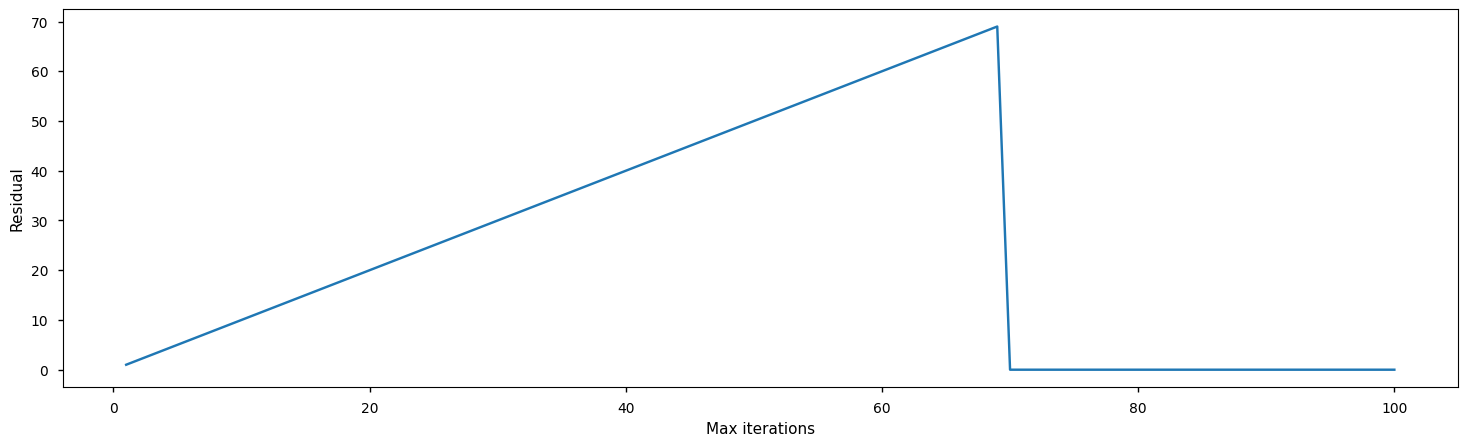

In [4]:
fig, ax = plt.subplots(1,figsize=(18, 5),dpi=100)

ax.plot(iters, res)
ax.set_xlabel("Max iterations")
ax.set_ylabel("Residual");

## SPAI preconditioning
The SPAI preconditioner is defined by

$$
\begin{align*}
\mathrm{C}_k &= \mathrm{A} \mathrm{M}_k\\
\mathrm{G}_k &= \mathrm{I} - \mathrm{C}_k\\
\alpha_k &=\operatorname{tr}(\mathrm{G}_k^\text{T}\mathrm{A}\mathrm{G}_k) / \|\mathrm{A}\mathrm{G}_k\|_\text{F}^2\\
\mathrm{M}_{k+1} &= \mathrm{M}_k + \alpha_k \mathrm{G}_k
\end{align*}
$$

Implement this preconditioner. Solve $\mathrm{A}\mathbf{x}=\mathrm{b}$ using $\mathrm{M}_m$ as a preconditioner for a range of values of $m$ and make a plot showing
the number of iterations vs the size of the residual for each of these.
If $m$ is too large, the preconditioner will take a long time to compute; if $m$ is too small, $\mathrm{M}_m$ will not be a good preconditioner. Experiment to find a good value to use for $m$.

You may wish to use the code included in [the preconditioning section of the lecture notes](https://tbetcke.github.io/hpc_lecture_notes/it_solvers4.html)
as a template.

In [5]:
def spai(A, m):
    """Perform m step of the SPAI iteration."""
    from scipy.sparse import identity
    from scipy.sparse import diags
    from scipy.sparse.linalg import onenormest
    
    n = A.shape[0]
    
    ident = identity(n, format='csr')
    alpha = 2 / onenormest(A @ A.T)
    M = alpha * A
        
    for index in range(m):
        C = A @ M
        G = ident - C
        AG = A @ G
        trace = (G.T @ AG).diagonal().sum()
        alpha = trace / np.linalg.norm(AG.data)**2
        M = M + alpha * G
        
    return M

In [11]:
M = spai(A, 4)

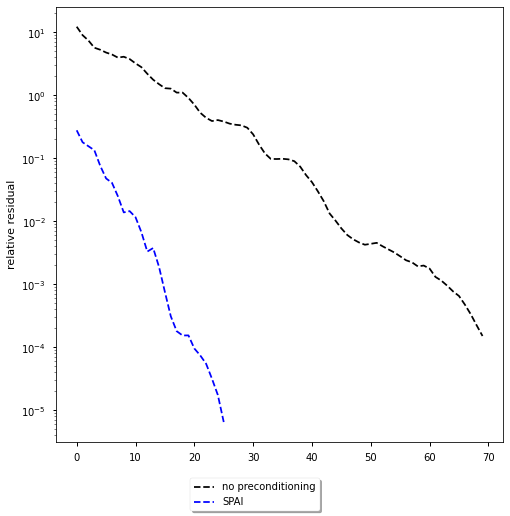

In [12]:
n = A.shape[0]
b = np.ones(n)

residuals = []
callback = lambda x: residuals.append(np.linalg.norm(A @ x - b))
x, _ = cg(A, b, callback=callback)

residuals_preconditioned = []
callback = lambda x: residuals_preconditioned.append(np.linalg.norm(A @ x - b) / np.linalg.norm(b))
x, _ = cg(A, b, M=M, callback=callback)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.semilogy(residuals, 'k--')
ax.semilogy(residuals_preconditioned, 'b--')
ax.set_ylabel('relative residual')
fig.legend(['no preconditioning', 'SPAI'], loc='lower center', fancybox=True, shadow=True);